In [1]:
import cobra
import os
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis


In [8]:
models = {}
model_dir = '../data/modelseed_models/'
for file in os.listdir(model_dir):
    if file.endswith('.json') and not file.endswith('gapfill_removed.json'):
        models[file.split('.json')[0]] = cobra.io.load_json_model(model_dir+file)

In [9]:
models

{'L. lactis': <Model L. lactis at 0x11b8f1978>,
 'B. vulgatus HM-720': <Model B. vulgatus HM-720 at 0x11fae5390>,
 'B. clarus': <Model B. clarus at 0x120247eb8>,
 'P. distasonis': <Model P. distasonis at 0x11faba630>,
 'C. saccharolyticum': <Model C. saccharolyticum at 0x1210d4358>,
 'L. plantarum': <Model L. plantarum at 0x120fb4278>,
 'P. merdae': <Model P. merdae at 0x121f2b780>,
 'R. gnavus': <Model R. gnavus at 0x122531048>}

In [4]:
for species,model in models.items():
    print(species,model.optimize())

L. lactis <Solution 37.156 at 0x11df91860>
B. vulgatus HM-720 <Solution 117.820 at 0x11b8f1da0>
B. clarus <Solution 114.214 at 0x11df90048>
P. distasonis <Solution 111.619 at 0x11cbdc0f0>
C. saccharolyticum <Solution 39.492 at 0x11df910f0>
L. plantarum <Solution 56.319 at 0x11df90048>
P. merdae <Solution 97.011 at 0x11df91860>
R. gnavus <Solution 25.340 at 0x11cbdc0f0>


In [10]:
# get the mapping of exchange reactions to metabolite names for every exchange reaction
ex_to_name = {}
for species in models.keys():
    ex_rxns = [r.id for r in models[species].reactions if r.id.startswith('EX_')]
    for rxn in ex_rxns:
        if rxn not in ex_to_name.keys():
            ex_to_name[rxn] = models[species].reactions.get_by_id(rxn).reactants[0].name

In [11]:
fva_results = {}
consumed_mets = {}
produced_mets = {}
for species,model in models.items():
    model.solver='glpk'
    print("performing FVA for {}".format(species))
    ex_rxns = [r.id for r in model.reactions if r.id.startswith('EX_')]
    fva_results[species] = flux_variability_analysis(model,ex_rxns, fraction_of_optimum = 0.05)
    
    # get consistently consumed and produced metabolites from exchanges
    consumed_mets[species] = fva_results[species].loc[(fva_results[species] < -1e-6).sum(axis=1) > 1]
    produced_mets[species] = fva_results[species].loc[(fva_results[species] > 1e-6).sum(axis=1) > 1]
    

performing FVA for L. lactis
performing FVA for B. vulgatus HM-720
performing FVA for B. clarus
performing FVA for P. distasonis
performing FVA for C. saccharolyticum
performing FVA for L. plantarum
performing FVA for P. merdae
performing FVA for R. gnavus


In [12]:
# extract the lowest uptake rates
species_consumption_series = {species:consumed_mets[species]['maximum'] for species in consumed_mets.keys()}
uptake_frame = pd.DataFrame(species_consumption_series)
uptake_frame = uptake_frame.fillna(0).T
# normalize the uptake frame by the max of the metabolite across all species
#uptake_frame = uptake_frame.divide(uptake_frame.min())

In [13]:
# extract the highest secretion rates
species_production_series = {species:produced_mets[species]['minimum'] for species in produced_mets.keys()}
secretion_frame = pd.DataFrame(species_production_series)
secretion_frame = secretion_frame.fillna(0).T
# normalize the uptake frame by the max of the metabolite across all species
#secretion_frame = uptake_frame.divide(uptake_frame.min())

In [14]:
# merge the secretion and uptake dataframes, then normalize by the absolute max secretion/uptake
con_prod_frame = secretion_frame.add(uptake_frame, fill_value=0)

# normalize by max(abs)
con_prod_frame = con_prod_frame.divide(abs(con_prod_frame).max(axis=1),axis=0)
# filter out metabolites with uptakes lower than 5% of max for all species
con_prod_frame = con_prod_frame[con_prod_frame.columns[abs(con_prod_frame).max() > 0.05]]
# Filter out metabolites for display
exclude = ['EX_cpd00001_e','EX_cpd00007_e'] # H2O, Oxygen, 
con_prod_frame = con_prod_frame[[col for col in con_prod_frame.columns if col not in exclude]]

In [15]:
con_prod_frame

,EX_cpd00009_e,EX_cpd00013_e,EX_cpd00023_e,EX_cpd00036_e,EX_cpd00039_e,EX_cpd00051_e,EX_cpd00060_e,EX_cpd00064_e,EX_cpd00065_e,EX_cpd00066_e,...,EX_cpd01133_e,EX_cpd03198_e,EX_cpd03847_e,EX_cpd10516_e,EX_cpd11583_e,EX_cpd11584_e,EX_cpd11606_e,EX_cpd15603_e,EX_cpd15605_e,EX_cpd15606_e
L. lactis,0.000000,0.0,0.000000,0.000000,-0.276167,-0.164086,0.000000,0.164086,0.000000,-0.149485,...,0.000000,0.000000,0.000000,-0.013473,-0.34136,-0.069528,0.000000,0.00000,0.000000,0.000000
B. vulgatus HM-720,-0.149160,-1.0,0.000000,0.000000,-0.062792,0.000000,-0.026476,0.000000,0.000000,-0.031253,...,0.000000,0.000000,-0.030352,-0.001487,0.00000,0.000000,-0.001879,0.00000,0.000000,0.000000
B. clarus,0.000000,0.0,0.000000,0.000000,-0.949434,0.000000,-0.400320,0.000000,0.000000,-0.472561,...,0.000000,0.000000,-0.458934,-0.023675,0.00000,0.000000,-0.018940,0.00000,0.000000,0.000000
P. distasonis,-1.000000,0.0,0.000000,0.000000,-0.419166,-0.626509,0.000000,0.000000,-0.063732,0.000000,...,0.000000,0.000000,-0.202615,-0.008362,0.00000,-0.107021,-0.012542,-0.27955,-0.208631,-0.162937
C. saccharolyticum,0.000000,0.0,0.000000,0.058719,0.000000,0.000000,-0.718381,0.000000,0.000000,-0.651515,...,-0.571011,0.000000,0.000000,-0.073399,0.00000,0.000000,-0.058719,0.00000,0.000000,0.000000
L. plantarum,0.000000,0.0,0.000000,0.000000,-0.276168,0.000000,-0.129978,0.000000,0.000000,-0.149486,...,0.000000,0.000000,0.000000,-0.013473,0.00000,0.000000,-0.013473,0.00000,0.000000,0.000000
P. merdae,-0.121947,0.0,0.000000,0.000000,-0.047716,-0.087890,0.000000,0.000000,-0.006779,0.000000,...,0.000000,0.000000,-0.023065,-0.000952,0.00000,-0.012183,-0.001428,0.00000,-0.023750,-0.018548
R. gnavus,-1.000000,0.0,-0.741877,0.013294,0.000000,0.000000,0.000000,0.000000,0.000000,-0.147498,...,0.000000,-0.258545,0.000000,-0.013294,0.00000,0.000000,-0.013294,0.00000,0.000000,0.000000


In [16]:
shadow_price_dict = {}
for species,model in models.items():
    medium = model.medium
    medium = {cpd:1 for cpd in medium.keys()}
    model.medium = medium
    shadow_prices = model.optimize().shadow_prices
    shadow_prices = shadow_prices[[cpd for cpd in shadow_prices.index if cpd.endswith('_e')]]
    shadow_price_dict[species] = shadow_prices
    
shadow_price_frame = pd.DataFrame(shadow_price_dict)
shadow_price_frame = shadow_price_frame.fillna(0)

# remove metabolites with small shadow prices
shadow_price_frame = shadow_price_frame.loc[abs(shadow_price_frame).max(axis=1) > 1e-8].T

#normalize shadow prices by the max(abs) for each species
shadow_price_frame = shadow_price_frame.divide(abs(shadow_price_frame).max(axis=1),axis=0)

In [17]:
shadow_price_frame

,cpd00007_e,cpd00011_e,cpd00013_e,cpd00024_e,cpd00027_e,cpd00033_e,cpd00053_e,cpd00054_e,cpd00067_e,cpd00080_e,...,cpd00276_e,cpd00277_e,cpd00309_e,cpd00311_e,cpd00314_e,cpd00367_e,cpd00396_e,cpd00550_e,cpd00588_e,cpd00794_e
L. lactis,-7.500000e-01,-0.583333,-8.333333e-02,0.000000,-5.000000e-01,0.0,-0.000000e+00,0.000000,-7.500000e-01,0.000000,...,-0.583333,0.000000,0.000000e+00,0.000000,-0.250000,0.000000,0.000000e+00,0.000000,0.000000,-1.000000e+00
B. vulgatus HM-720,-6.161243e-15,-0.000000,-1.000000e+00,0.000000,-7.684671e-15,0.0,0.000000e+00,0.000000,-1.988173e-15,0.000000,...,0.000000,0.000000,-6.845394e-16,0.000000,0.000000,0.000000,-5.574817e-16,0.000000,0.000000,0.000000e+00
B. clarus,-1.428571e-01,-0.000000,-1.975011e-15,0.000000,-8.571429e-01,0.0,0.000000e+00,0.000000,4.521754e-16,-0.357143,...,0.000000,-0.071429,-0.000000e+00,-0.142857,0.000000,-0.071429,0.000000e+00,0.000000,0.000000,0.000000e+00
P. distasonis,-1.276030e-16,-0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,-2.500000e-01,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.000000e+00,0.000000,0.000000,0.000000e+00
C. saccharolyticum,-0.000000e+00,-1.000000,-5.000000e-01,0.000000,-3.650720e-17,-1.0,-5.000000e-01,-1.000000,-5.000000e-01,0.000000,...,-0.500000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.650720e-16
L. plantarum,-1.666667e-01,-0.250000,-0.000000e+00,-0.083333,-5.000000e-01,-0.0,-4.433704e-16,-0.083333,-2.500000e-01,0.000000,...,-0.500000,0.000000,-8.333333e-02,0.000000,-0.416667,0.000000,0.000000e+00,-0.083333,-0.416667,-1.000000e+00
P. merdae,-1.818182e-01,-0.000000,0.000000e+00,0.000000,-1.000000e+00,0.0,0.000000e+00,0.000000,-2.207741e-16,0.000000,...,0.000000,0.000000,-2.114321e-15,0.000000,0.000000,0.000000,-9.090909e-01,0.000000,0.000000,0.000000e+00
R. gnavus,0.000000e+00,-1.000000,9.028194e-16,0.000000,-1.305172e-14,0.0,0.000000e+00,0.000000,-5.000000e-01,0.000000,...,-0.500000,0.000000,-0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00


In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
# set the colormap and centre the colorbar - from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


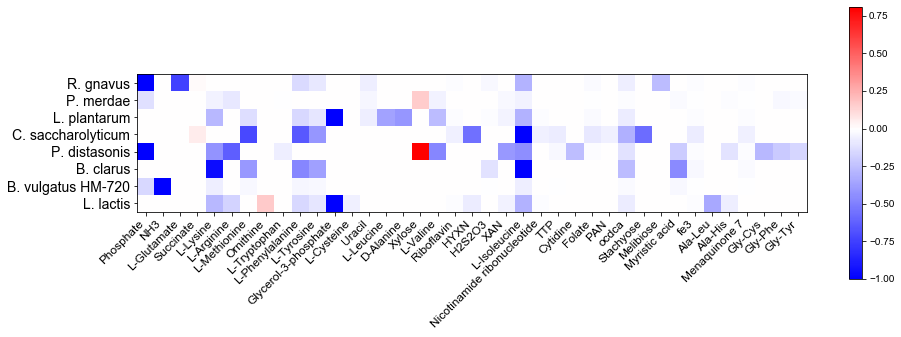

In [41]:
fig,ax = plt.subplots()
plt.rcParams["font.family"] = "Arial"

elev_min=con_prod_frame.min().min()
elev_max=con_prod_frame.max().max()
mid_val=0

im= ax.imshow(con_prod_frame.values, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# construct the custom colormap

#im = ax.imshow(con_prod_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(con_prod_frame.columns)))
ax.set_yticks(np.arange(len(con_prod_frame.index)))
ax.set_ylim((-0.5,len(con_prod_frame.index)-0.5))
labels = [ex_to_name[exchange] for exchange in con_prod_frame.columns]
ax.set_xticklabels(labels, rotation = 45, ha = 'right', size=12)
# convert xtick labels to metabolite names

ax.set_yticklabels(con_prod_frame.index, size=14)
plt.colorbar(im)
fig.set_size_inches(15,5)
plt.savefig('../results/fva_filtered.svg')

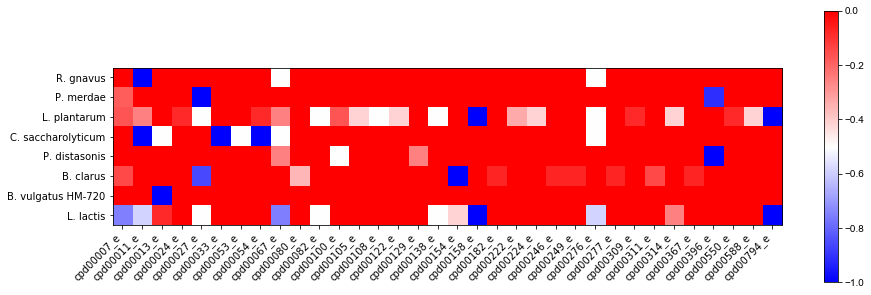

In [34]:
fig,ax = plt.subplots()
# construct the custom colormap

im = ax.imshow(shadow_price_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(shadow_price_frame.columns)))
ax.set_yticks(np.arange(len(shadow_price_frame.index)))
ax.set_ylim((-0.5,len(shadow_price_frame.index)-0.5))
ax.set_xticklabels(shadow_price_frame.columns, rotation = 45, ha = 'right')
ax.set_yticklabels(shadow_price_frame.index)
plt.colorbar(im)
fig.set_size_inches(15,5)

In [28]:
# Construct the bin packing problem for these 8 species based on the filtered FVA results and assign to 2 bins
from optlang.cplex_interface import Model, Variable, Constraint, Objective
from optlang.symbolics import add
import pandas as pd

# need to multiply each consumption/production by 100 to get them (abs()) all above 1 (they were filtered to >0.05)
met_multi = 100.
# our binary variables are the presence and absence of each item in each bin. We need one variable per item per bin to describe this.
bins = 2
species_vars = {}
placement_constraints = []
metabolite_sums = {}
bin_names = []
all_constraints = []
for i in range(0,bins):
    bin_name = 'bin'+str(i+1)
    bin_names.append(bin_name)
    species_vars[bin_name] = {}
    species_name_mapping = {}
    for species in models.keys():
        spec_name = species.replace(' ','_') # replace white space, not allowed in optland
        species_name_mapping[species] = spec_name
        species_vars[bin_name][spec_name] = Variable(spec_name+'_'+bin_name, lb=0, ub = 1, type='integer')
        
    
    #                             
    metabolite_sums[bin_name] = {}
    for metabolite in con_prod_frame.columns:
        
        metabolite_sums[bin_name][metabolite] = add(
            [met_multi*-1*con_prod_frame.loc[species,metabolite]*species_vars[bin_name][species_name_mapping[species]] for species in models.keys()])

# We need one constraint for each species to require that a species is placed in exactly one bin.
for species in models.keys():
    placement_constraints.append(Constraint(add([species_vars[bin_name][species_name_mapping[species]] for bin_name in bin_names]), lb = 1, ub = 1))

summation = []
for bin_name in bin_names:
    for metabolite in metabolite_sums[bin_name].keys():
        summation.append(metabolite_sums[bin_name][metabolite])

cost_min = Objective(add([term**2 for term in summation]), direction='min', sloppy=False)

model = Model(name='2 bins')
model.objective = cost_min
model.add(placement_constraints)#,lower_constraint,upper_constraint])#,cost_constr])

In [30]:
model.optimize()

'optimal'

In [31]:
print(model.objective.value)
for var_name, var in model.variables.items():
    print(var_name, "=", var.primal)

211760.69628919518
B._clarus_bin1 = 1.0
B._clarus_bin2 = 0.0
B._vulgatus_HM-720_bin1 = 0.0
B._vulgatus_HM-720_bin2 = 1.0
C._saccharolyticum_bin1 = 0.0
C._saccharolyticum_bin2 = 1.0
L._lactis_bin1 = 0.0
L._lactis_bin2 = 1.0
L._plantarum_bin1 = 1.0
L._plantarum_bin2 = 0.0
P._distasonis_bin1 = 0.0
P._distasonis_bin2 = 1.0
P._merdae_bin1 = 1.0
P._merdae_bin2 = 0.0
R._gnavus_bin1 = 1.0
R._gnavus_bin2 = 0.0


In [ ]:
# find best pairs for each species for consumption of produced metabolites
for species,consumed in consumed_mets.items():
    best_overlap = (None,0)
    print('Finding partner for {}'.format(species))
    for paired_species,produced in produced_mets.items():
        overlap = len(produced.intersection(consumed))
        print('\toverlap with {0}: {1}'.format(paired_species,overlap))
        if overlap > best_overlap[1]:
            best_overlap = (paired_species,overlap)
    print('best partner was {0} with overlap of {1}'.format(best_overlap[0],best_overlap[1]))

In [ ]:
# Find best pairs of species based on minimization of consumption overlap
for species,consumed in consumed_mets.items():
    best_overlap = (None,1000000)
    print('Finding partner for {}'.format(species))
    for paired_species,pair_consumption in consumed_mets.items():
        overlap = len(pair_consumption.intersection(consumed))
        print('\toverlap with {0}: {1}'.format(paired_species,overlap))
        if overlap < best_overlap[1]:
            best_overlap = (paired_species,overlap)
    print('best partner was {0} with overlap of {1}'.format(best_overlap[0],best_overlap[1]))

In [32]:
import itertools
iterable = consumed_mets.keys()
all_species = set(iterable)
r = 4
combos = []
for r in range(0,9):
    for combo in itertools.combinations(iterable,r):
        combos.append(set(combo))

contains_all = []

for combo in combos:
    for combo2 in combos:
        if len(combo) + len(combo2) == len(all_species):
            union = combo.union(combo2)
            if len(union) == len(all_species):
                contains_all.append((combo,combo2))

In [33]:
# How many combinations are there that fit in the two bins?
len(contains_all)

256